In [2]:
%reset -f
%matplotlib inline

import os

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

from nilearn import datasets, plotting, input_data, signal  # for fetching atlas

from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nistats.reporting import plot_design_matrix
from nistats.design_matrix import make_design_matrix

import seaborn as sns
sns.reset_orig()

from fctools import denoise, stats

/home/finc/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
t_r = 2
n_scans = 340

onsets_dir = '/home/finc/Dropbox/Projects/LearningBrain/github/LearningBrain_networks/support/onsets_dualnback.csv'
events = pd.read_csv(onsets_dir)
frame_times = np.arange(n_scans) * t_r

#------ step 1
box = make_design_matrix(frame_times, events, hrf_model = None)
box = box.reset_index()

# ----- step 2

box_hrf = make_design_matrix(frame_times, events, hrf_model = 'glover')
box_hrf  = box_hrf.reset_index()

/home/finc/anaconda/lib/python3.6/site-packages/nistats/utils.py:182: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


Implementation of GLM weighting procedure 
============================

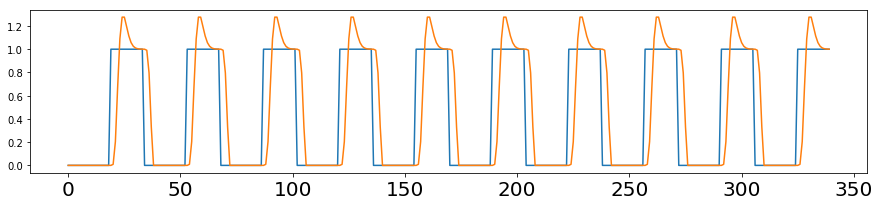

In [50]:
rect_box_hrf = np.array([0 if elem < 0 else elem for elem in box_hrf['2-back']])
plt.figure(figsize = (15, 3))
plt.plot(box['2-back'])
plt.plot(rect_box_hrf)



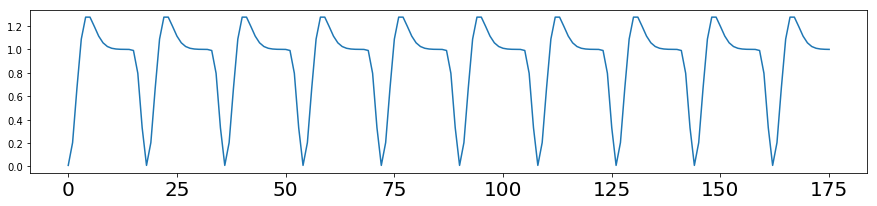

In [51]:
rect_nnz = rect_box_hrf[np.nonzero(rect_box_hrf)]
plt.figure(figsize = (15, 3))
plt.plot(rect_nnz)


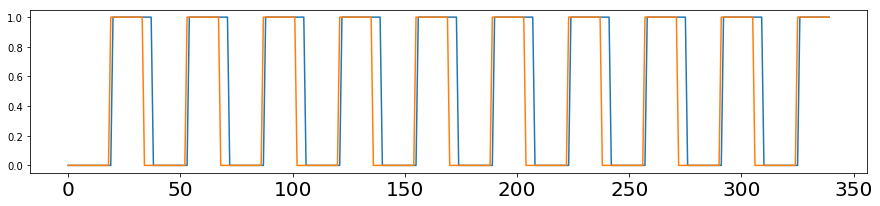

In [52]:
plt.figure(figsize = (15, 3))
plt.plot(box_hrf['2-back'] > 0)
plt.plot(box['2-back'])

Calculate correlation matrices - normal way
----------------------------------------------------


In [8]:


data0 = np.load(top_dir + 'LearningBrain_correlation_matrices_calculated_in_conn.npy')
data1 = np.load(top_dir + 'LearningBrain_dualnback_timeseries_acomp_anat_12par_008_25.npy')
data2 = np.load(top_dir + 'LearningBrain_dualnback_timeseries_acomp_anat_24par_008_25.npy')

data3 = np.load(top_dir + 'LearningBrain_dualnback_timeseries_anat_12par_008_25.npy')
data4 = np.load(top_dir + 'LearningBrain_dualnback_timeseries_anat_24par_008_25.npy')

data5 = np.load(top_dir + 'LearningBrain_dualnback_timeseries_acompcor_12par_008_25.npy')
data6 = np.load(top_dir + 'LearningBrain_dualnback_timeseries_acompcor_24par_008_25.npy')

data7 = np.load(top_dir + 'LearningBrain_dualnback_timeseries_acompcor_temp_deriv_12par_008_25.npy')
data8 = np.load(top_dir + 'LearningBrain_dualnback_timeseries_acompcor_temp_deriv_24par_008_25.npy')

data9 = np.load(top_dir + 'LearningBrain_dualnback_timeseries_acompcor_temp_deriv_24par_008_25_smoothed.npy')
data10 = np.load(top_dir + 'LearningBrain_dualnback_timeseries_acompcor_24par_008_25_smoothed.npy')

In [5]:
top_dir = '/home/finc/Dropbox/Projects/LearningBrain/data/neuroimaging/'

In [29]:
data10 = np.load(top_dir + 'LearningBrain_dualnback_timeseries_acompcor_24par_008_25_smoothed.npy')

In [274]:
data0.shape

(46, 4, 2, 264, 264)

In [113]:
#from sklearn.covariance import EmpiricalCovariance

data = data3

sub_n = len(data[:, 0, 0, 0])
ses_n = len(data[0, :, 0, 0])
cond = ['1-back', '2-back']
rois_n = len(data[0, 0, 0, :])


correlation_matrices = np.zeros((sub_n, ses_n, len(cond), rois_n, rois_n))


for sub in range(sub_n):
    for ses in range(ses_n):                 
        correlation_measure = ConnectivityMeasure(kind = 'correlation')
        
        for con in range(len(cond)):
            
            timeseries_dual = data[sub, ses, box[cond[con]].values > 0.9, :]
            
            fc = correlation_measure.fit_transform([timeseries_dual])[0]
            np.fill_diagonal(fc, 0)
                        
            correlation_matrices[sub, ses, con, :, :] = np.arctanh(fc)
            
correlation_matrices.shape

(46, 4, 2, 264, 264)

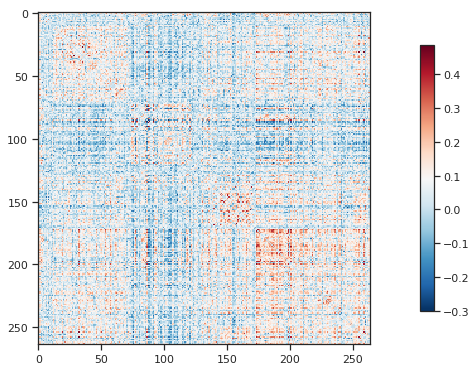

In [114]:
plotting.plot_matrix(correlation_matrices[1,0,0,:,:])


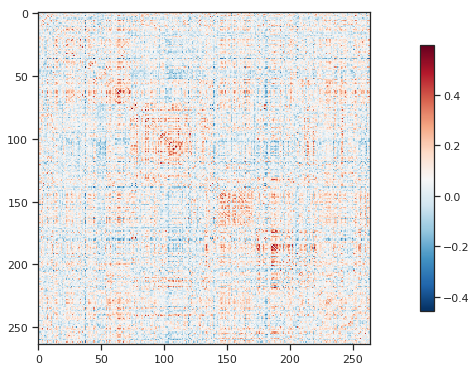

In [115]:
plotting.plot_matrix(correlation_matrices[8,0,1,:,:])


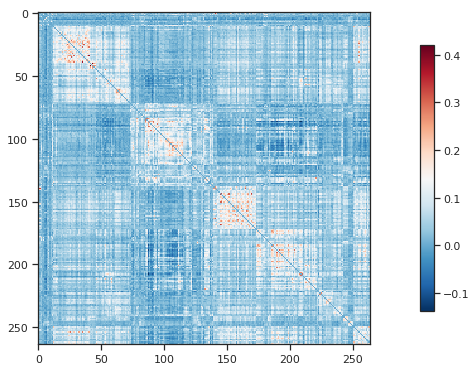

In [116]:
mean_nback_nor = correlation_matrices.mean(axis = 0)

plotting.plot_matrix(mean_nback_nor[3,0,:,:])


In [ ]:
plotting.plot_matrix(mean_nback_nor[3,1,:,:])

Calculating correlation matricices - weighted GLM
-----------------------------------------------------

In [30]:
from sklearn.covariance import EmpiricalCovariance
data = data10

sub_n = len(data[:, 0, 0, 0])
ses_n = len(data[0, :, 0, 0])
cond = ['1-back', '2-back']
rois_n = len(data[0, 0, 0, :])


correlation_matrices_wei = np.zeros((sub_n, ses_n, len(cond), rois_n, rois_n))


for sub in range(sub_n):
    for ses in range(ses_n):                 
        correlation_measure = ConnectivityMeasure(cov_estimator=EmpiricalCovariance(store_precision=True, assume_centered=False), kind = 'correlation', discard_diagonal=True)
        
        for con in range(len(cond)):
            rect_box_hrf = np.array([0 if elem < 0 else elem for elem in box_hrf[cond[con]]])
            rect_nnz = rect_box_hrf[np.nonzero(rect_box_hrf)]
                        
            timeseries_dual = data[sub, ses, rect_box_hrf > 0, :]
            
            timeseries_dual = (timeseries_dual.T * rect_nnz).T
            
            fc = correlation_measure.fit_transform([timeseries_dual])[0]
            np.fill_diagonal(fc, 0)
                        
            correlation_matrices_wei[sub, ses, con, :, :] = np.arctanh(fc)
            
correlation_matrices_wei.shape


(46, 4, 2, 264, 264)

In [285]:
correlation_matrices_wei = data0

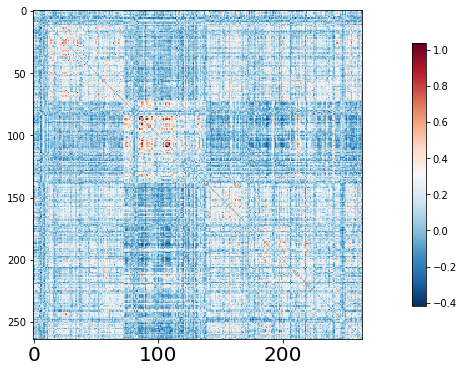

In [72]:
plotting.plot_matrix(correlation_matrices_wei[8,3,0,:,:])


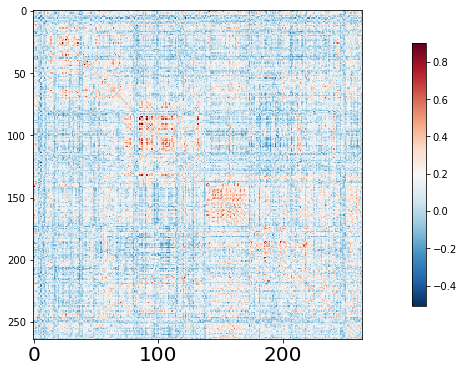

In [73]:
plotting.plot_matrix(correlation_matrices_wei[8,3,1,:,:])


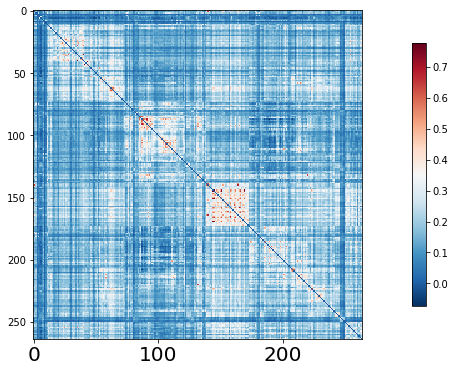

In [74]:
mean_nback_wei = correlation_matrices_wei.mean(axis = 0)
plotting.plot_matrix(mean_nback_wei[3,0,:,:])


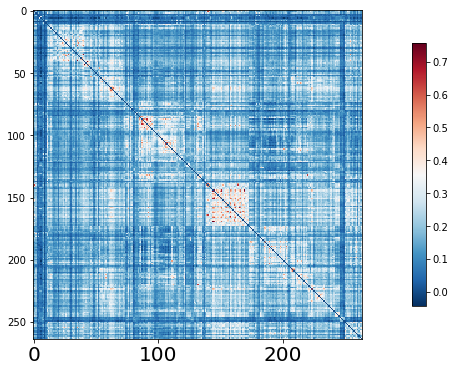

In [75]:
plotting.plot_matrix(mean_nback_wei[3,1,:,:])


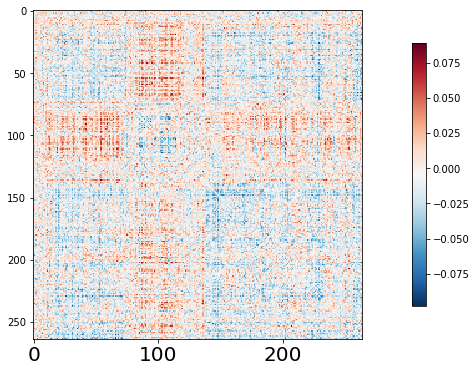

In [76]:
plotting.plot_matrix(mean_nback_wei[0,1,:,:] - mean_nback_wei[0,0,:,:])


In [77]:
n_sub = len(correlation_matrices_wei[:,0,0,0,0])
n_ses = len(correlation_matrices_wei[0,:,0,0,0])
n_con = len(correlation_matrices_wei[0,0,:,0,0])

# ---------------
sess = ['ses-1', 'ses-2', 'ses-3', 'ses-4']
cond = ['1-back', '2-back']

# Selecting subjects which finished the study
groups = pd.read_csv('/home/finc/Dropbox/Projects/LearningBrain/github/LearningBrain_networks/data/behavioral/group_assignment.csv')

trained = (groups.group == 'Experimental') | (groups.group == 'Control')
trained_subs = groups[trained]['sub']
trained_group = pd.Series.tolist(groups[trained]['group'])

subs = pd.Series.tolist(trained_subs)

dualnback_exclude = ['sub-13', 'sub-21', 'sub-23', 'sub-50'] # higly motion subjects in one of four sessions
subs_incl = [x for x in subs if x not in dualnback_exclude]


In [78]:
import bct

Q_results = pd.DataFrame()
gamma = 1
n_rep = 10

Q_results = pd.DataFrame(columns=['sub', 'group', 'ses', 'cond', 'Q'])
for sub in range(n_sub):
    print(f'Calculating modularity of subject {subs[sub]}')
    for ses in range(n_ses):
        for con in range(n_con):
            #A = data0[sub, ses, con, :, :]
            A = correlation_matrices_wei[sub, ses, con, :, :]
            
            cost_tot = np.mean(A[A != 0]) #--- mean of all weigths 
            cost_pos = np.mean(A[A > 0])  # --- mean of positive weights
            cost_neg = np.mean(A[A < 0]) # --- mean of negative weights
                        
            [ci,Q] = bct.modularity_louvain_und_sign(A, gamma)
            for i in range(n_rep):
                [cit, Qt] = bct.modularity_louvain_und_sign(A, gamma)
                if Qt > Q:
                    Q = Qt
                    ci = cit
            result = pd.DataFrame([[subs[sub], trained_group[sub], sess[ses], cond[con], cost_tot, cost_pos, cost_neg, Q]], 
                                  columns=['sub', 'group', 'ses', 'cond', 'mean_FC', 'mean_FC+', 'meanFC-', 'Q'])
            Q_results = pd.concat([Q_results, result], axis = 0)


Calculating modularity of subject sub-01


/home/finc/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Calculating modularity of subject sub-02
Calculating modularity of subject sub-04
Calculating modularity of subject sub-05
Calculating modularity of subject sub-06
Calculating modularity of subject sub-07
Calculating modularity of subject sub-08
Calculating modularity of subject sub-10
Calculating modularity of subject sub-11
Calculating modularity of subject sub-12
Calculating modularity of subject sub-13
Calculating modularity of subject sub-14
Calculating modularity of subject sub-15
Calculating modularity of subject sub-16
Calculating modularity of subject sub-18
Calculating modularity of subject sub-19
Calculating modularity of subject sub-20
Calculating modularity of subject sub-21
Calculating modularity of subject sub-23
Calculating modularity of subject sub-24
Calculating modularity of subject sub-25
Calculating modularity of subject sub-26
Calculating modularity of subject sub-27
Calculating modularity of subject sub-28
Calculating modularity of subject sub-29
Calculating modu

In [80]:
Q_results.to_csv('/home/finc/Dropbox/Projects/LearningBrain/data/neuroimaging/modularity_data6.csv', sep = ',', index = False)


In [ ]:
np.Q_results

In [81]:
Q_results_filtered = Q_results.loc[Q_results['sub'].isin(subs_incl)]

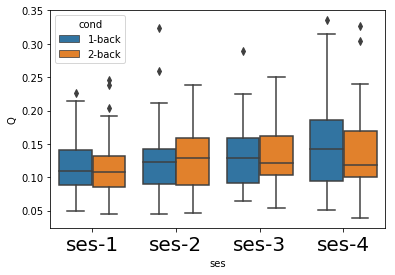

In [82]:
sns.boxplot(x = "ses", y = "Q", hue = "cond", data = Q_results_filtered)


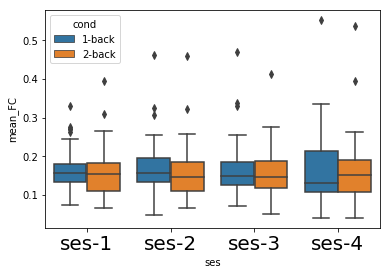

In [83]:
sns.boxplot(x = "ses", y = "mean_FC", hue = "cond", data = Q_results_filtered)


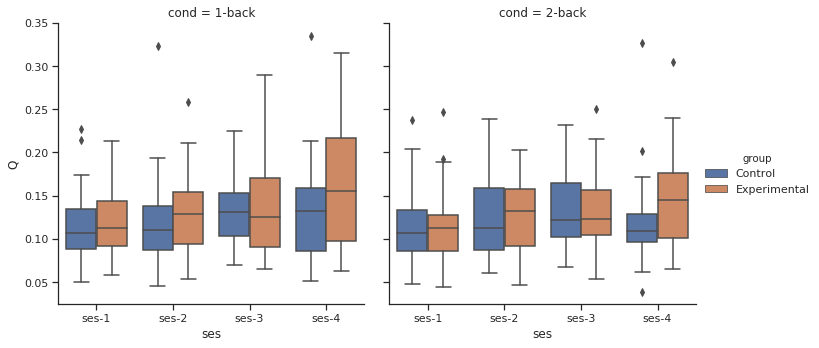

In [91]:
# nilearn conn style + smoothing
sns.set(style="ticks")
sns.catplot(x = "ses", y = "Q", hue = "group", col = 'cond', data = Q_results_filtered, kind = "box")

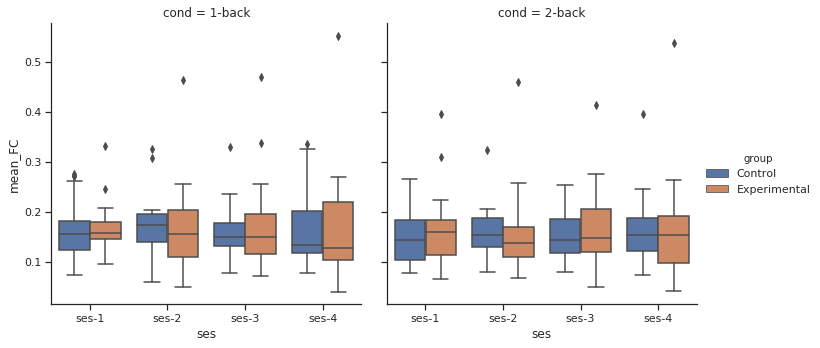

In [92]:
sns.catplot(x = "ses", y = "mean_FC", hue = "group", col = 'cond', data = Q_results_filtered, kind = "box")

In [44]:
conn = np.load(f'{top_dir}LearningBrain_correlation_matrices_calculated_in_conn.npy')

In [45]:
conn.shape

(46, 4, 2, 264, 264)

In [88]:
diag = np.zeros((264))

matrix_bin = vec_to_sym_matrix(x, diagonal = diag)



Weighted correlation - static connectivity
---------------------------

In [10]:
data = data6

sub_n = len(data[:, 0, 0, 0])
ses_n = len(data[0, :, 0, 0])
cond = ['1-back', '2-back']
rois_n = len(data[0, 0, 0, :])
A = np.zeros((rois_n, rois_n))
correlation_matrices_wei = np.zeros((sub_n, ses_n, len(cond), rois_n, rois_n))


for sub in range(1):
    print(f'Calculating correlations: sub {sub}')
    for ses in range(ses_n):                 
        #correlation_measure = ConnectivityMeasure(cov_estimator=EmpiricalCovariance(store_precision=True, assume_centered=False), kind = 'correlation', discard_diagonal=True)
        
        for con in range(len(cond)):
            #--- zeroing negative values
            rect_box_hrf = np.array([0 if elem < 0 else elem for elem in box_hrf[cond[con]]])
            #--- concatenating nonzeros blocs
            rect_nnz = rect_box_hrf[np.nonzero(rect_box_hrf)]
            #--- filtering            
            timeseries_dual = data[sub, ses, rect_box_hrf > 0, :]
            #--- calculating weighted correlation coefficient
            for i in range(rois_n):
                for j in range(i):
                    if i == j:
                        continue
                    else:
                        A[i, j] = stats.corr_wei(timeseries_dual[:, i], timeseries_dual[:, j], rect_nnz)
            
            fc = A + A.T
            correlation_matrices_wei[sub, ses, con, :, :] = np.arctanh(fc)
            
correlation_matrices_wei.shape

Calculating correlations: sub 0


(46, 4, 2, 264, 264)

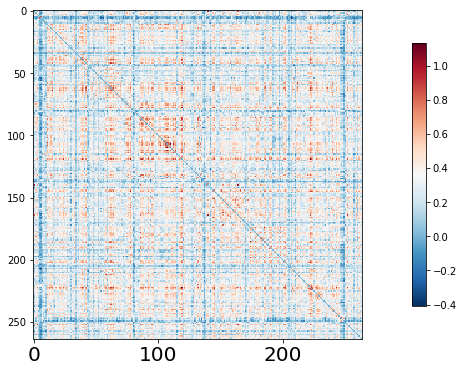

In [17]:
plotting.plot_matrix(correlation_matrices_wei[0,1,0,:,:])

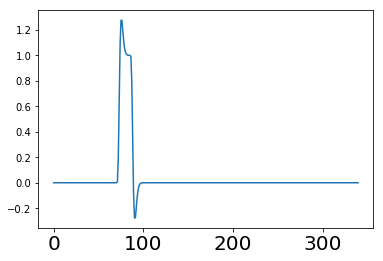

In [18]:
t_r = 2
n_scans = 340

onsets_dir = '/home/finc/Dropbox/Projects/LearningBrain/github/LearningBrain_networks/support/onsets_dualnback.csv'
events = pd.read_csv(onsets_dir)
frame_times = np.arange(n_scans) * t_r

events = events[(events.trial_type == '1-back') | (events.trial_type == '2-back')].reset_index()
events['trial_type'] = np.arange(20)

#------ step 1
box_hrf = make_design_matrix(frame_times, events, hrf_model = 'glover')
box_hrf  = box_hrf.reset_index()
plt.plot(box_hrf.iloc[:,5])

In [ ]:
data = np.load(f'{top_dir}LearningBrain_dualnback_timeseries_acompcor_24par_008_25_no_smooth_power.npy')

sub_n = len(data[:, 0, 0, 0])
ses_n = len(data[0, :, 0, 0])
cond = np.arange(0,20)
rois_n = len(data[0, 0, 0, :])
A = np.zeros((rois_n, rois_n))
correlation_matrices_dyn_wei = np.zeros((sub_n, ses_n, len(cond), rois_n, rois_n))


for sub in range(sub_n):
    print(f'Calculating correlations: sub {sub}')
    for ses in range(ses_n):                 
        #correlation_measure = ConnectivityMeasure(cov_estimator=EmpiricalCovariance(store_precision=True, assume_centered=False), kind = 'correlation', discard_diagonal=True)
        
        for con in range(len(cond)):
            #--- zeroing negative values
            rect_box_hrf = np.array([0 if elem < 0 else elem for elem in box_hrf[cond[con]]])
            #--- concatenating nonzeros blocs
            rect_nnz = rect_box_hrf[np.nonzero(rect_box_hrf)]
            #--- filtering            
            timeseries_dual = data[sub, ses, rect_box_hrf > 0, :]
            #--- calculating weighted correlation coefficient
            for i in range(rois_n):
                for j in range(i):
                    if i == j:
                        continue
                    else:
                        A[i, j] = stats.corr_wei(timeseries_dual[:, i], timeseries_dual[:, j], rect_nnz)
            
            fc = A + A.T
            correlation_matrices_dyn_wei[sub, ses, con, :, :] = np.arctanh(fc)
            
correlation_matrices_dyn_wei.shape

Calculating correlations: sub 0
Calculating correlations: sub 1
Calculating correlations: sub 2
Calculating correlations: sub 3
Calculating correlations: sub 4
Calculating correlations: sub 5
Calculating correlations: sub 6
Calculating correlations: sub 7
Calculating correlations: sub 8
Calculating correlations: sub 9
Calculating correlations: sub 10
Calculating correlations: sub 11
Calculating correlations: sub 12
Calculating correlations: sub 13
Calculating correlations: sub 14
Calculating correlations: sub 15
Calculating correlations: sub 16
Calculating correlations: sub 17
Calculating correlations: sub 18
Calculating correlations: sub 19
Calculating correlations: sub 20
Calculating correlations: sub 21
Calculating correlations: sub 22
Calculating correlations: sub 23
Calculating correlations: sub 24
Calculating correlations: sub 25
Calculating correlations: sub 26
Calculating correlations: sub 27
Calculating correlations: sub 28
Calculating correlations: sub 29
Calculating correlat

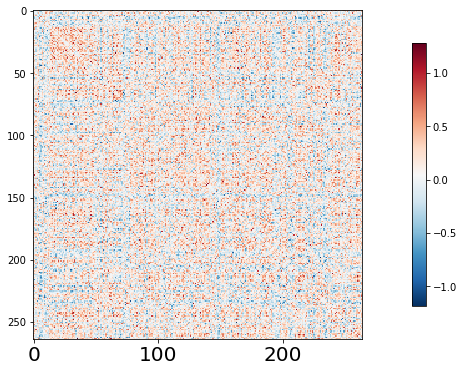

In [31]:
plotting.plot_matrix(correlation_matrices_dyn_wei[0,0,1,:,:])

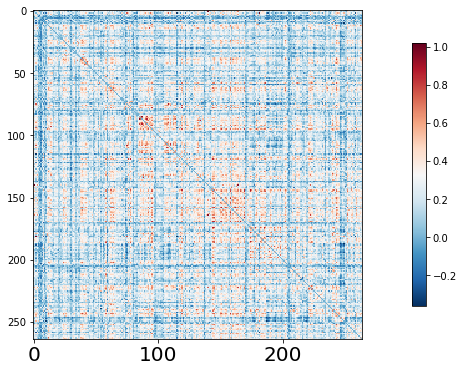

In [26]:
plotting.plot_matrix(correlation_matrices_dyn_wei[0,0,5,:,:])

In [109]:
import scipy.io as sio

sio.savemat(top_dir + 'LearningBrain_dFC_matrices_dualnback_wei.mat', {'correlation_matrices_dyn_wei': correlation_matrices_dyn_wei})


In [1]:
correlation_matrices_dyn_wei[46, 4, 2, 264, 264]

NameError: name 'correlation_matrices_dyn_wei' is not defined